# Proficiency Level Identification. BERT baseline
Pauline Claes

In [2]:
# mount Google Drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
%cd "/content/drive/MyDrive/NLP_SharedTask"

/content/drive/MyDrive/NLP_SharedTask


In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from simpletransformers.classification import ClassificationModel, ClassificationArgs

import matplotlib.pyplot as plt
import seaborn as sn 

In [5]:
df = pd.read_csv("train.csv")

In [1]:
#!pip install simpletransformers==0.60.9

In [6]:
df = df.drop(columns=['Filename', 'Language'])


In [7]:
df.rename(columns={'Proficiency': 'labels'}, inplace=True)

In [8]:
train, dev = train_test_split(df, 
                              test_size = 0.1,
                              random_state=1,
                              shuffle=True,
                              stratify = df.labels)

In [9]:
train, test = train_test_split(train, 
                               test_size=0.1, 
                               random_state=1, 
                               shuffle=True, 
                               stratify=train.labels)

In [10]:
# explore train set
print('-'*10, "TRAIN", '-'*10)
print("Number of essays (train):", len(train))
print("train:", train[['labels']].value_counts(sort=False))

print('-'*10, "DEV", '-'*10)
print("Number of essays (dev):", len(dev))
print("dev:", dev[['labels']].value_counts(sort=False))

print('-'*10, "TEST", '-'*10)
print("Number of essays (test):", len(test))
print("test:", test[['labels']].value_counts(sort=False))

---------- TRAIN ----------
Number of essays (train): 8910
train: labels
high      3106
low        973
medium    4831
dtype: int64
---------- DEV ----------
Number of essays (dev): 1100
dev: labels
high      384
low       120
medium    596
dtype: int64
---------- TEST ----------
Number of essays (test): 990
test: labels
high      345
low       108
medium    537
dtype: int64


In [11]:
model_args = ClassificationArgs()

model_args.overwrite_output_dir=True
model_args.labels_list=['high', 'medium', 'low'] 
model_args.evaluate_during_training=True

model_args.num_train_epochs=6
model_args.train_batch_size=64
model_args.learning_rate=1e-5 
model_args.max_seq_length=128

model_args.use_early_stopping=True
model_args.early_stopping_delta=0.01
model_args.early_stopping_metric='eval_loss'
model_args.early_stopping_metric_minimize=True 
model_args.early_stopping_patience=2 
model_args.evaluate_during_training_steps=34

model_args.evaluate_during_training_silent=False
model_args.evaluate_each_epoch=False

In [12]:
steps_per_epoch = int(np.ceil(len(train) / float(model_args.train_batch_size)))
print('Each epoch will have {:,} steps.'.format(steps_per_epoch))

Each epoch will have 140 steps.


In [13]:
bert_model = ClassificationModel('bert', 'bert-base-cased', num_labels=3, args=model_args, use_cuda=True) 

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [14]:
_, bert_history = bert_model.train_model(train, eval_df=dev)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/140 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/138 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/138 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/138 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/138 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/140 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/138 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/138 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/138 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/138 [00:00<?, ?it/s]

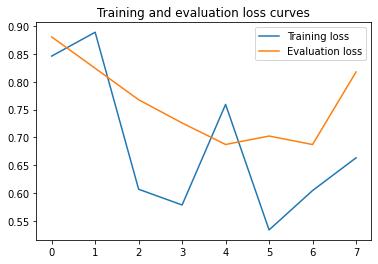

In [15]:
train_loss = bert_history['train_loss']
eval_loss = bert_history['eval_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.title('Training and evaluation loss curves')
plt.legend()
plt.show()

In [16]:
predicted, probabilities = bert_model.predict(test['text'].to_list())
test['predicted'] = predicted

  0%|          | 0/124 [00:00<?, ?it/s]

In [17]:
print(f1_score(test['labels'], test['predicted'], average="macro"))

0.504230879215588


In [18]:
print(classification_report(test['labels'], test['predicted']))

              precision    recall  f1-score   support

        high       0.58      0.93      0.71       345
         low       0.90      0.08      0.15       108
      medium       0.73      0.58      0.65       537

    accuracy                           0.65       990
   macro avg       0.74      0.53      0.50       990
weighted avg       0.70      0.65      0.62       990



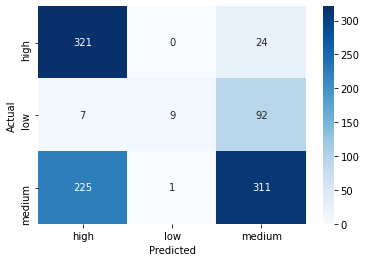

In [19]:
confusion_matrix = pd.crosstab(test['labels'], test['predicted'], rownames=['Actual'], colnames=['Predicted']) 
sn.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.show()